Verinin okunması ve eksik veri kontrolü

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



df = pd.read_csv('Life Expectancy Data.csv')

missing_data = df[df.isnull().any(axis=1)]

print(missing_data)


       Country  Year      Status  Life expectancy   Adult Mortality  \
32     Algeria  2015  Developing              75.6             19.0   
44     Algeria  2003  Developing              71.7            146.0   
45     Algeria  2002  Developing              71.6            145.0   
46     Algeria  2001  Developing              71.4            145.0   
47     Algeria  2000  Developing              71.3            145.0   
...        ...   ...         ...               ...              ...   
2918    Zambia  2003  Developing              46.4             64.0   
2919    Zambia  2002  Developing              45.5             69.0   
2920    Zambia  2001  Developing              44.6            611.0   
2921    Zambia  2000  Developing              43.8            614.0   
2922  Zimbabwe  2015  Developing              67.0            336.0   

      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
32               21      NaN                0.000000         95.0   

Eksik verilerin ısı haritası

Visualizing missing data:


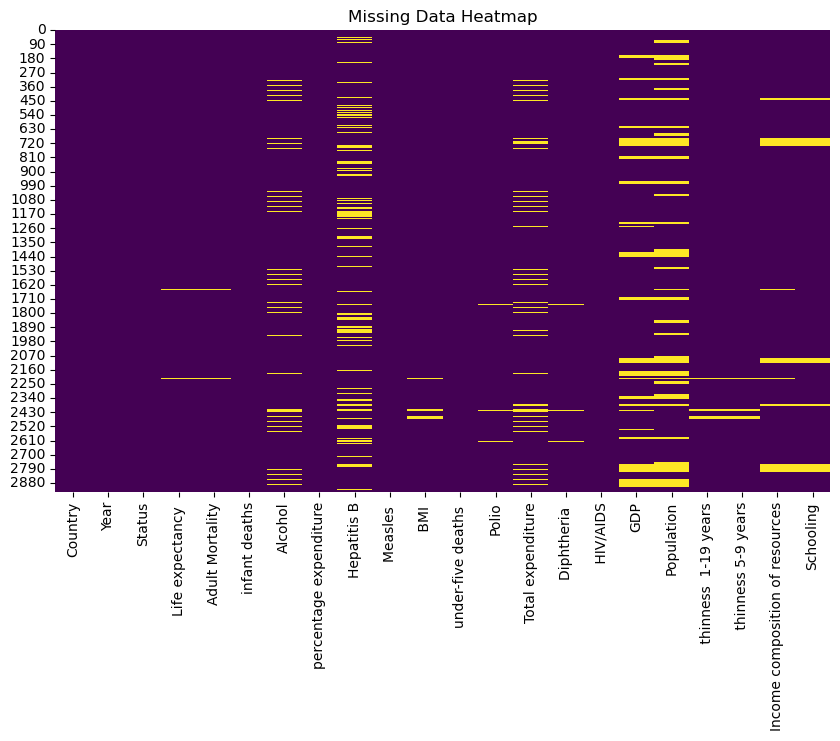

In [4]:
def plot_missing_data(data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Data Heatmap")
    plt.show()

print("Visualizing missing data:")
plot_missing_data(df)

In [5]:
missing_counts = df.isnull().sum()

print("Her sütundaki eksik veri sayıları:")
print(missing_counts)


Her sütundaki eksik veri sayıları:
Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64


Verileri standartlaştırma

In [6]:


scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))  # Only scale numeric data
scaled_df = pd.DataFrame(scaled_data, columns=df.select_dtypes(include=[np.number]).columns)




Kolonları teker teker eksik var mı yok mu kontrol ediyoruz. Eksik olan verileri test, eksik olmayanları train verisi olarak ayırıyoruz. Modeli eğitirken satırlarda herhangi bir eksik olamamsı için eksik satır içeren verileri temizliyoruz. Model eğitilip eksik veriler tamamlanıyor. (Modelin çalışması biraz uzun sürüyor)

In [7]:
for col in scaled_df.columns:
    if scaled_df[col].isnull().sum() > 0:  # If the column has missing values
        print(f"Imputing missing values for column: {col}")
        
        # Separate rows with and without missing values
        train_data = scaled_df[scaled_df[col].notnull()]
        test_data = scaled_df[scaled_df[col].isnull()]
        
        # Use other columns as features
        X_train = train_data.drop(columns=[col]).values
        y_train = train_data[col].values
        X_test = test_data.drop(columns=[col]).values
        
        # Handle missing values in X_train and X_test
        valid_train_rows = ~np.isnan(X_train).any(axis=1)  # Remove rows with NaN in X_train
        X_train = X_train[valid_train_rows]
        y_train = y_train[valid_train_rows]
        
        # Temporarily fill NaNs in X_test with column means (or another strategy)
        X_test = np.nan_to_num(X_test, nan=np.nanmean(X_train, axis=0))
        
        # Define the Gaussian Process model
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
        
        # Fit the model
        gpr.fit(X_train, y_train)
        
        # Predict the missing values
        y_pred, y_std = gpr.predict(X_test, return_std=True)
        
        # Fill the missing values
        scaled_df.loc[scaled_df[col].isnull(), col] = y_pred

Imputing missing values for column: Life expectancy 
Imputing missing values for column: Adult Mortality
Imputing missing values for column: Alcohol
Imputing missing values for column: Hepatitis B
Imputing missing values for column:  BMI 
Imputing missing values for column: Polio
Imputing missing values for column: Total expenditure
Imputing missing values for column: Diphtheria 
Imputing missing values for column: GDP
Imputing missing values for column: Population
Imputing missing values for column:  thinness  1-19 years
Imputing missing values for column:  thinness 5-9 years
Imputing missing values for column: Income composition of resources
Imputing missing values for column: Schooling


In [8]:
imputed_data = scaler.inverse_transform(scaled_df)
imputed_df = pd.DataFrame(imputed_data, columns=df.select_dtypes(include=[np.number]).columns)

# Replace the original numeric columns with imputed values
for col in imputed_df.columns:
    df[col] = imputed_df[col]



missing_counts = df.isnull().sum()

print("Her sütundaki eksik veri sayıları:")
print(missing_counts)

Her sütundaki eksik veri sayıları:
Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64


Visualizing missing data after imputation:


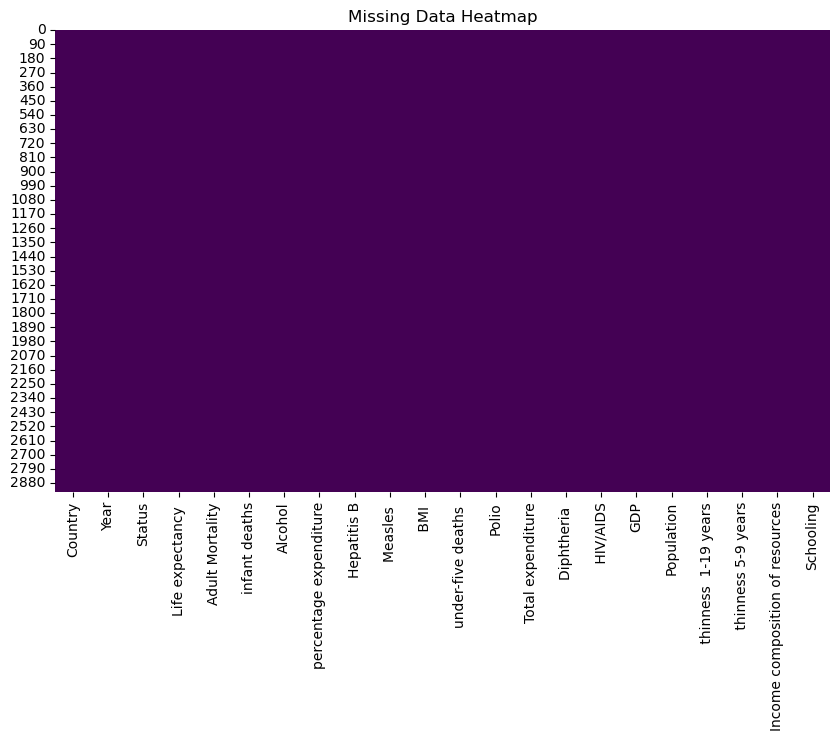

Statistics before imputation:
              Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2938.000000      2938.000000   2.938000e+03   
mean   2007.518720         69.229152       164.797847   3.030395e+01   
std       4.613841          9.508858       124.080926   1.179265e+02   
min    2000.000000         36.300000         1.000000   3.552714e-15   
25%    2004.000000         63.200000        74.000000   3.552714e-15   
50%    2008.000000         72.000000       144.000000   3.000000e+00   
75%    2012.000000         75.600000       227.000000   2.200000e+01   
max    2015.000000         89.000000       723.000000   1.800000e+03   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2938.000000             2938.000000  2938.000000    2938.000000   
mean      4.508798              738.251295    80.809078    2419.592240   
std       3.971026             1987.914858    22.712313   11467.272489   
min      -3.567327       

In [10]:
from sklearn.linear_model import LinearRegression
print("Visualizing missing data after imputation:")
plot_missing_data(df)

# Compare statistics before and after imputation
print("Statistics before imputation:")
print(df.describe())

# Machine Learning Performance Analysis
# Define a sample target column and features
target_col = 'Life expectancy '  # Replace with your target column
if target_col in df.columns:
    df = df.dropna(subset=[target_col])
    features = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
    target = df[target_col]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train a baseline model (with missing data handled) using Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print("Model performance with imputed data:")
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("R-squared:", r2_score(y_test, y_pred))
else:
    print(f"Target column '{target_col}' is not found in the dataset.")